# CNN Forecasting - Copper Producer Price Index

#### Attributions

The below code uses the template from the [Intro to TensorFlow for Deep Learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187) tutorial, of which the original authors **(Copyright 2018 The TensorFlow Authors)** have made available under the Apache 2.0 license.

Modifications have been made to the below code for the purpose of generating appropriate analyses on the hotel cancellations dataset. The original source code can be found [here](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb#scrollTo=PgYwn9VM8OJi).

#### Apache 2.0 Licence

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(1234)

keras = tf.keras

In [3]:
from numpy.random import seed
seed(1)
from pandas import DataFrame

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
df=pd.read_csv("copper_price_index.csv")
df

,Date,Value
0,1985-09-01,99.2
1,1985-10-01,99.1
2,1985-11-01,99.2
3,1985-12-01,99.4
4,1986-01-01,100.4
...,...,...
414,2020-03-01,350.3
415,2020-04-01,341.6
416,2020-05-01,345.9
417,2020-06-01,355.4


In [6]:
df['Value'] = np.log(df['Value'])
df

,Date,Value
0,1985-09-01,4.597138
1,1985-10-01,4.596129
2,1985-11-01,4.597138
3,1985-12-01,4.599152
4,1986-01-01,4.609162
...,...,...
414,2020-03-01,5.858790
415,2020-04-01,5.833640
416,2020-05-01,5.846150
417,2020-06-01,5.873244


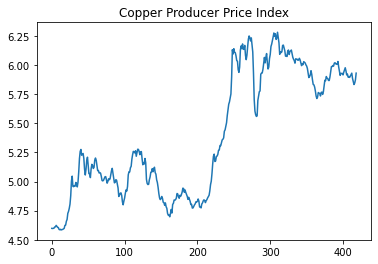

In [7]:
series=df['Value']
series=np.array(series)
plt.plot(series)
plt.title("Copper Producer Price Index")
plt.show()

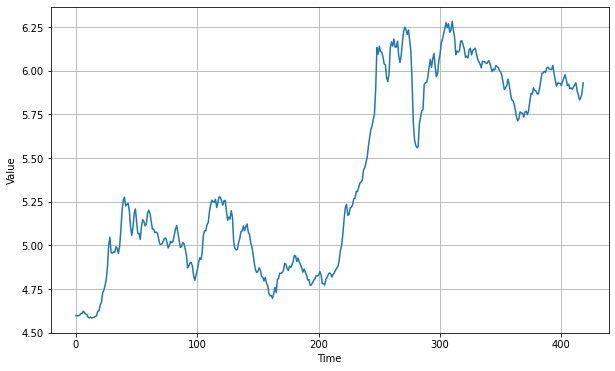

In [8]:
time = np.arange(0, 419)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [9]:
split_time = 334
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=32)
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [11]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
10/10 [==============================] - 0s 7ms/step - loss: 132.1384 - mae: 132.6384 - lr: 1.0000e-08
Epoch 2/50
10/10 [==============================] - 0s 6ms/step - loss: 131.3660 - mae: 131.8660 - lr: 1.1220e-08
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 130.1820 - mae: 130.6820 - lr: 1.2589e-08
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 128.7399 - mae: 129.2399 - lr: 1.4125e-08
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 127.0755 - mae: 127.5755 - lr: 1.5849e-08
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 125.1886 - mae: 125.6886 - lr: 1.7783e-08
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 123.0516 - mae: 123.5516 - lr: 1.9953e-08
Epoch 8/50
10/10 [==============================] - 0s 8ms/step - loss: 120.6424 - mae: 121.1423 - lr: 2.2387e-08
Epoch 9/50
10/10 [==============================] - 0s 7ms/step - loss: 117.9235 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

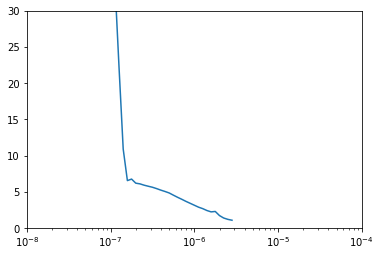

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [13]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

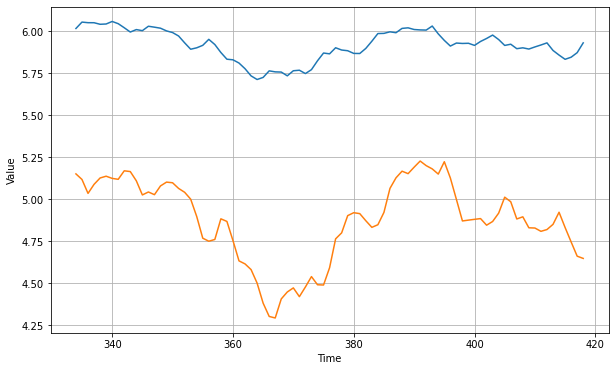

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.0405409

In [16]:
np.mean(x_valid)

5.918858805178803

## Fully Convolutional Forecasting

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h6", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      1/Unknown - 0s 9us/step - loss: 4.6053 - mae: 5.1053WARNING:tensorflow:From /home/michael/.local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
3/3 [==============================] - 2s 551ms/step - loss: 4.5885 - mae: 5.0885 - val_loss: 5.1672 - val_mae: 5.6672
Epoch 2/500
3/3 [==============================] - 1s 348ms/step - loss: 4.5062 - mae: 5.0062 - val_loss: 5.0634 - val_mae: 5.5634
Epoch 3/500
3/3 [==============================] - 1s 399ms/step - loss: 4.4112 - mae: 4.9112 - val_loss: 4.9437 - val_mae: 5.4437
Epoch 4/500
3/3 [==============================] - 1s 382ms/step - loss: 4.3020 - mae: 4.8020 - val_loss: 4.8078 - val_mae:

3/3 [==============================] - 1s 466ms/step - loss: 0.8491 - mae: 1.2783 - val_loss: 0.9248 - val_mae: 1.3592
Epoch 31/500
3/3 [==============================] - 2s 630ms/step - loss: 0.7720 - mae: 1.1893 - val_loss: 0.8321 - val_mae: 1.2476
Epoch 32/500
3/3 [==============================] - 2s 617ms/step - loss: 0.6935 - mae: 1.0912 - val_loss: 0.7423 - val_mae: 1.1315
Epoch 33/500
3/3 [==============================] - 2s 590ms/step - loss: 0.6171 - mae: 0.9907 - val_loss: 0.6559 - val_mae: 1.0132
Epoch 34/500
3/3 [==============================] - 2s 723ms/step - loss: 0.5430 - mae: 0.8894 - val_loss: 0.5734 - val_mae: 0.8993
Epoch 35/500
3/3 [==============================] - 2s 667ms/step - loss: 0.4722 - mae: 0.7930 - val_loss: 0.4986 - val_mae: 0.8060
Epoch 36/500
3/3 [==============================] - 2s 660ms/step - loss: 0.4076 - mae: 0.7130 - val_loss: 0.4319 - val_mae: 0.7123
Epoch 37/500
3/3 [==============================] - 2s 664ms/step - loss: 0.3499 - mae: 0

3/3 [==============================] - 1s 485ms/step - loss: 0.0290 - mae: 0.1792 - val_loss: 0.0286 - val_mae: 0.1487
Epoch 62/500
3/3 [==============================] - 2s 555ms/step - loss: 0.0264 - mae: 0.1725 - val_loss: 0.0285 - val_mae: 0.1581
Epoch 63/500
3/3 [==============================] - 1s 479ms/step - loss: 0.0248 - mae: 0.1642 - val_loss: 0.0239 - val_mae: 0.1396
Epoch 64/500
3/3 [==============================] - 1s 496ms/step - loss: 0.0228 - mae: 0.1624 - val_loss: 0.0207 - val_mae: 0.1286
Epoch 65/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0214 - mae: 0.1575 - val_loss: 0.0219 - val_mae: 0.1414
Epoch 66/500
3/3 [==============================] - 2s 501ms/step - loss: 0.0202 - mae: 0.1498 - val_loss: 0.0183 - val_mae: 0.1238
Epoch 67/500
3/3 [==============================] - 1s 494ms/step - loss: 0.0189 - mae: 0.1475 - val_loss: 0.0167 - val_mae: 0.1173
Epoch 68/500
3/3 [==============================] - 2s 559ms/step - loss: 0.0180 - mae: 0.

3/3 [==============================] - 2s 513ms/step - loss: 0.0087 - mae: 0.1061 - val_loss: 0.0051 - val_mae: 0.0747
Epoch 102/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0087 - mae: 0.1070 - val_loss: 0.0069 - val_mae: 0.0917
Epoch 103/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0087 - mae: 0.1038 - val_loss: 0.0057 - val_mae: 0.0810
Epoch 104/500
3/3 [==============================] - 1s 463ms/step - loss: 0.0085 - mae: 0.1053 - val_loss: 0.0043 - val_mae: 0.0694
Epoch 105/500
3/3 [==============================] - 0s 14ms/step - loss: 0.0090 - mae: 0.1103 - val_loss: 0.0063 - val_mae: 0.0876
Epoch 106/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0085 - mae: 0.1024 - val_loss: 0.0063 - val_mae: 0.0884
Epoch 107/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0084 - mae: 0.1038 - val_loss: 0.0044 - val_mae: 0.0703
Epoch 108/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0083 - mae: 

Epoch 153/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0064 - mae: 0.0869 - val_loss: 0.0028 - val_mae: 0.0604
Epoch 154/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0060 - mae: 0.0890 - val_loss: 0.0028 - val_mae: 0.0606
Epoch 155/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0059 - mae: 0.0866 - val_loss: 0.0042 - val_mae: 0.0765
Epoch 156/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0059 - mae: 0.0855 - val_loss: 0.0029 - val_mae: 0.0614
Epoch 157/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0058 - mae: 0.0865 - val_loss: 0.0034 - val_mae: 0.0666
Epoch 158/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0058 - mae: 0.0851 - val_loss: 0.0034 - val_mae: 0.0674
Epoch 159/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0058 - mae: 0.0853 - val_loss: 0.0031 - val_mae: 0.0633
Epoch 160/500
3/3 [==============================] - 0s 18ms/step - loss: 0.

Epoch 212/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0041 - mae: 0.0713 - val_loss: 0.0020 - val_mae: 0.0517
Epoch 213/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0041 - mae: 0.0709 - val_loss: 0.0020 - val_mae: 0.0519
Epoch 214/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - mae: 0.0707 - val_loss: 0.0023 - val_mae: 0.0556
Epoch 215/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - mae: 0.0699 - val_loss: 0.0018 - val_mae: 0.0486
Epoch 216/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0041 - mae: 0.0721 - val_loss: 0.0022 - val_mae: 0.0540
Epoch 217/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - mae: 0.0695 - val_loss: 0.0019 - val_mae: 0.0508
Epoch 218/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0040 - mae: 0.0707 - val_loss: 0.0018 - val_mae: 0.0487
Epoch 219/500
3/3 [==============================] - 0s 18ms/step - loss: 0.

Epoch 266/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0030 - mae: 0.0603 - val_loss: 0.0015 - val_mae: 0.0453
Epoch 267/500
3/3 [==============================] - 2s 695ms/step - loss: 0.0029 - mae: 0.0577 - val_loss: 9.6659e-04 - val_mae: 0.0363
Epoch 268/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0030 - mae: 0.0608 - val_loss: 0.0021 - val_mae: 0.0551
Epoch 269/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0581 - val_loss: 0.0011 - val_mae: 0.0382
Epoch 270/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0029 - mae: 0.0597 - val_loss: 0.0018 - val_mae: 0.0500
Epoch 271/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0029 - mae: 0.0567 - val_loss: 9.8181e-04 - val_mae: 0.0364
Epoch 272/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0032 - mae: 0.0631 - val_loss: 0.0026 - val_mae: 0.0617
Epoch 273/500
3/3 [==============================] - 0s 22ms/step -

3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - mae: 0.0405 - val_loss: 6.1825e-04 - val_mae: 0.0283
Epoch 380/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - mae: 0.0406 - val_loss: 0.0011 - val_mae: 0.0393
Epoch 381/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - mae: 0.0406 - val_loss: 6.7343e-04 - val_mae: 0.0296
Epoch 382/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - mae: 0.0404 - val_loss: 7.8943e-04 - val_mae: 0.0323
Epoch 383/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0403 - val_loss: 0.0010 - val_mae: 0.0373
Epoch 384/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0015 - mae: 0.0401 - val_loss: 6.5760e-04 - val_mae: 0.0293
Epoch 385/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0401 - val_loss: 0.0011 - val_mae: 0.0397
Epoch 386/500
3/3 [==============================] - 2s 512ms/step - loss:

3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0361 - val_loss: 6.2609e-04 - val_mae: 0.0286
Epoch 492/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0361 - val_loss: 5.0479e-04 - val_mae: 0.0255
Epoch 493/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0012 - mae: 0.0359 - val_loss: 6.4499e-04 - val_mae: 0.0291
Epoch 494/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0013 - mae: 0.0360 - val_loss: 6.2226e-04 - val_mae: 0.0285
Epoch 495/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0013 - mae: 0.0359 - val_loss: 4.9592e-04 - val_mae: 0.0253
Epoch 496/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0359 - val_loss: 5.7549e-04 - val_mae: 0.0274
Epoch 497/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0012 - mae: 0.0359 - val_loss: 5.0826e-04 - val_mae: 0.0257
Epoch 498/500
3/3 [==============================] - 0s 19ms/s

In [18]:
model = keras.models.load_model("my_checkpoint.h6")

In [19]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

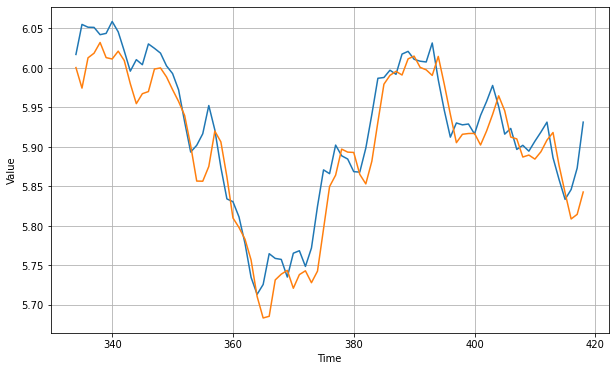

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

0.027838342

In [22]:
x_valid

array([6.01713229, 6.05514332, 6.05161847, 6.05138304, 6.04215766,
       6.04381978, 6.05888952, 6.04571596, 6.02150867, 5.99595445,
       6.01053161, 6.00413395, 6.03044485, 6.02489932, 6.01883649,
       6.00265174, 5.99296342, 5.97228173, 5.93171454, 5.89357605,
       5.90208674, 5.916741  , 5.95246381, 5.92157842, 5.87408768,
       5.83422577, 5.83070877, 5.81144035, 5.77765232, 5.73495809,
       5.71340272, 5.72587007, 5.76487757, 5.75890177, 5.75763915,
       5.73528114, 5.76550453, 5.76863345, 5.74875584, 5.77206398,
       5.82481947, 5.87099039, 5.86618473, 5.90236007, 5.88887796,
       5.88471418, 5.86873178, 5.86816633, 5.89852655, 5.94122333,
       5.98695439, 5.98795841, 5.99719808, 5.99196442, 6.0176195 ,
       6.02102335, 6.01102205, 6.00856746, 6.00758393, 6.03164634,
       5.98494333, 5.94620564, 5.91242134, 5.9303867 , 5.92799212,
       5.92905709, 5.91647157, 5.93990806, 5.9576492 , 5.97787259,
       5.95116325, 5.91620206, 5.92345334, 5.8968791 , 5.90208

In [23]:
cnn_forecast

array([6.000511 , 5.974504 , 6.012833 , 6.0187106, 6.032278 , 6.0131087,
       6.011381 , 6.021288 , 6.009443 , 5.9801254, 5.9548345, 5.967439 ,
       5.970117 , 5.9986444, 6.000058 , 5.98865  , 5.9726024, 5.9575744,
       5.939885 , 5.90173  , 5.856829 , 5.8566403, 5.8753176, 5.9200997,
       5.9064255, 5.8620744, 5.810161 , 5.798051 , 5.7831006, 5.7569685,
       5.7107897, 5.683492 , 5.6856093, 5.731644 , 5.7389474, 5.743748 ,
       5.721129 , 5.7384167, 5.7432027, 5.728165 , 5.742821 , 5.79625  ,
       5.849893 , 5.8642964, 5.8972774, 5.8934746, 5.8930635, 5.865325 ,
       5.853246 , 5.8819213, 5.93163  , 5.9794645, 5.9906373, 5.9957356,
       5.9911003, 6.011515 , 6.01502  , 6.00073  , 5.997656 , 5.99057  ,
       6.01467  , 5.979154 , 5.9412885, 5.9054327, 5.9160523, 5.917031 ,
       5.9171777, 5.902493 , 5.9202256, 5.941281 , 5.964751 , 5.945827 ,
       5.9125   , 5.91022  , 5.887255 , 5.8897524, 5.884643 , 5.8939753,
       5.9087   , 5.9183183, 5.8766656, 5.8419743, 